# Détection d'objet : version simplifiée de YOLO

<center> <img src="https://drive.google.com/uc?id=1V4aAS7K_Akj83apuMZ2vRjNvjgdgoOCh" width=500></center>
<caption><center> Pipeline de l'algorithme YOLO ([Redmon 2016]) </center></caption>

Dans ce TP, nous allons tenter d'aller un peu plus loin que le TP précédent en considérant le problème plus complexe de la détection d'objet, c'est-à-dire de la localisation et la classification conjointe de tous les objets dans l'image ; pour cela nous allons implémenter une version simplifiée de YOLO. Cette version est considérée simplifiée car ne reprenant pas l'intégralité des éléments décrite dans l'article de Redmon (par exemple, sur le choix de l'optimiseur). Une des simplifications principales est également que nous ne considérerons **qu'un objet par cellule**.

Pour rappel, l'idée de YOLO est de découper l'image en une grille de cellules et de réaliser une prédiction de plusieurs boîtes englobantes ainsi qu'une classification par cellule. La vidéo de la cellule suivante rappelle les concepts vus en cours sur YOLO et la détection d'objet en général.



In [1]:
from IPython.display import IFrame
IFrame("https://video.polymny.studio/?v=012cd29c-db98-458f-80d3-6cc5c1da9be3/", width=640, height=360)

Récupération des données

In [2]:
!git clone https://github.com/axelcarlier/wildlife.git

Cloning into 'wildlife'...
remote: Enumerating objects: 2973, done.
remote: Total 2973 (delta 0), reused 0 (delta 0), pack-reused 2973
Receiving objects: 100% (2973/2973), 433.18 MiB | 19.97 MiB/s, done.
Updating files: 100% (3008/3008), done.



## Fonctions utiles

Définition des différentes variables utiles pour la suite

In [3]:
IMAGE_SIZE = 64 # Dimension des images en entrée du réseau
CELL_PER_DIM = 8 # Nombre de cellules en largeur et en hauteur
BOX_PER_CELL = 1 # Nombre d'objets par cellule
NB_CLASSES = 4 # Nombre de classes du problème
PIX_PER_CELL = round(IMAGE_SIZE/CELL_PER_DIM)

CLASS_LABELS = ['buffalo', 'elephant', 'rhino', 'zebra']

### Chargement des données

On charge les images dans la dimension demandée, dans un tenseur $x$. Pour les labels, on ne les structure pas directement dans le format YOLO, mais on les place dans une liste de liste de listes : la longueur de la liste parente est celle du nombre d'images de la base, celle de la liste intermédiaire est celle du nombre d'objets d'une image donnée, et enfin la liste de plus bas niveau a une longueur 5 et contiendra les coordonnées de boîte englobante et les labels de classe associés.

In [4]:
import numpy as np

import math


import PIL
from PIL import Image
import glob, os, sys

for file in glob.glob("*.txt"):
    print(file)

def load_data_detection(ds_path):

  y_paths = []
  # Détermination du nombre d'images total
  for c in CLASS_LABELS:
    path = ds_path + c + '/'
    for file in os.listdir(path):
      if file.endswith('.txt'):
          y_paths.append(os.path.join(path, file))

  dataset_size = len(y_paths)

  # Préparation des structures de données pour x et y
  x = np.zeros((dataset_size, IMAGE_SIZE, IMAGE_SIZE, 3))
  y = []

  for i in range(len(y_paths)):
    text_path = y_paths[i]
    img_path = text_path[:-3] + 'jpg'

    if not os.path.exists(img_path):
      img_path = text_path[:-3] + 'JPG'

    # Lecture de l'image : on va remplir la variable x
    # Lecture de l'image
    img = Image.open(img_path)
    # Mise à l'échelle de l'image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    # Remplissage de la variable x
    x[i] = np.asarray(img, dtype=np.int32)

    # Texte : coordonnées de boîtes englobantes pour remplir y
    boxes = []
    # Texte : coordonnées de boîtes englobantes pour remplir y
    text_file = open(text_path, "r")
    # Récupération des lignes du fichier texte
    rows = text_file.read().split('\n')
    # Parcours de chaque ligne
    for row in rows:
      if row != '':
        # Séparation des différentes informations
        row = list(row.split(' '))
        box = []
        # réorganisation : les 4 coordonnées de boîte englobantes (castées en flottants) d'abord
        for r in row[1:]:
          box.append(float(r))

        box_normal = [box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2]

        # Puis le label de classe (casté en entier) à la suite
        box.append(int(row[0]))
        boxes.append(box)

    y.append(boxes)
  return x, y

# Chemin vers la base de données
ds_path = "./wildlife/"
x ,y = load_data_detection(ds_path)


<ipython-input-4-8915990f6f87>:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)


### Affichage des données

Le code ci-dessous vous permettra d'afficher les images ainsi que leurs boîtes englobantes associées. On peut spécifier l'id d'une image en particulier ou, si l'on en spécifie pas, visualiser une image aléatoire.

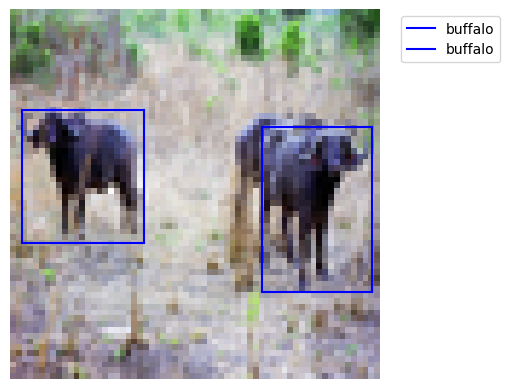

In [5]:
from scipy.special import softmax
import matplotlib.pyplot as plt

def print_data_detection(x, y, id=None, classes=CLASS_LABELS, image_size=IMAGE_SIZE):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0])
  else:
    num_img = id

  img = x[num_img]
  if np.max(img) > 1:
    img = img/255
  boxes = y[num_img]

  colors = ["blue", "yellow", "red", "orange"] # Différentes couleurs pour les différentes classes

  # Affichage de l'image
  plt.imshow(img)
  for box in boxes:

    # Détermination de la classe
    class_id = box[4]

    # Détermination des extrema de la boîte englobante
    p_x = [(box[0]-box[2]/2) * IMAGE_SIZE, (box[0]+box[2]/2) * IMAGE_SIZE]
    p_y = [(box[1]-box[3]/2) * IMAGE_SIZE, (box[1]+box[3]/2) * IMAGE_SIZE]

    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id], label=classes[class_id])
    #plt.title("Vérité Terrain : Image {}".format(num_img, classes[class_id]))

  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.axis('off')
  plt.show()


print_data_detection(x, y, id=22)


### Écriture des labels au format YOLO

Les deux fonctions ci-dessous sont essentielles car elles permettent de convertir les boîtes englobantes dans le format adopté par YOLO (voir la section Modèle un peu plus bas), mais également de faire l'opération inverse afin d'interpréter la sortie du réseau.

Notez que la fonction *get_box_from_yolo* intègre dans les boîtes englobantes une information supplémentaire par rapport aux données chargées initialement : la probabilité de présence associée à la boîte englobante.

In [6]:
from tensorflow.keras.utils import to_categorical
from scipy.special import expit, softmax


def set_box_for_yolo(y, num_classes=NB_CLASSES, image_size=IMAGE_SIZE, cell_size=PIX_PER_CELL):
  nb_cells_per_dim = round(image_size/cell_size)

  y_YOLO = np.zeros((len(y), nb_cells_per_dim, nb_cells_per_dim, 1 + 4 + num_classes))

  for i in range(len(y)):
    for box in y[i]:
      # Coordonnées du centre de la boîte englobante dans le repère image
      cx, cy = box[0] * image_size, box[1] * image_size
      # Détermination des indices de la cellule dans laquelle tombe le centre
      ind_x, ind_y = int(cx // cell_size), int(cy // cell_size)
      # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
      # On va donc calculer les coordonnées du centre relativement à la cellule dans laquelle il se situe
      y_YOLO[i, ind_x, ind_y, 1] = (cx - ind_x * cell_size) / cell_size
      y_YOLO[i, ind_x, ind_y, 2] = (cy - ind_y * cell_size) / cell_size
      # Largeur et hauteur de boîte
      y_YOLO[i, ind_x, ind_y, 3] = box[2]
      y_YOLO[i, ind_x, ind_y, 4] = box[3]

      # Indice de confiance de la boîte englobante pour la cellule correspondante
      y_YOLO[i, ind_x, ind_y, 0] = 1
      # On range les probabilités de classe à la fin du vecteur ([ Présence ; cx ; cy ; w ; h ; CLASSES])
      y_YOLO[i, ind_x, ind_y, 5:] = to_categorical(box[4], num_classes=num_classes)

  return y_YOLO

# Si mode = 'pred', il s'agit d'une prédiction du réseau, il faut alors utiliser la fonction sigmoide
# pour obtenir la présence prédite, et la fonction softmax pour obtenir les probabilités de classe
def get_box_from_yolo(y_YOLO, mode=None, confidence_threshold=0.5, num_classes=NB_CLASSES, image_size=IMAGE_SIZE, cell_size=PIX_PER_CELL):
  nb_cells_per_dim = round(image_size/cell_size)

  y = []
  for i in range(y_YOLO.shape[0]):
    boxes = []
    for ind_x in range(cell_size):
      for ind_y in range(cell_size):
        if mode == 'pred':
          presence = expit(y_YOLO[i, ind_x, ind_y, 0])
          classes_probabilities = softmax(y_YOLO[i, ind_x, ind_y, 5:])
          # coords = expit(y_YOLO[i, ind_x, ind_y, 1:5])
        else:
          presence = y_YOLO[i, ind_x, ind_y, 0]
          classes_probabilities = y_YOLO[i, ind_x, ind_y, 5:]

        coords = y_YOLO[i, ind_x, ind_y, 1:5]
        if presence > confidence_threshold:

          box = []
          box.append((coords[0] * cell_size + ind_x * cell_size) / image_size)
          box.append((coords[1] * cell_size + ind_y * cell_size) / image_size)
          box.append(coords[2])
          box.append(coords[3])
          box.append(np.argmax(y_YOLO[i, ind_x, ind_y, 5:]))
          box.append(presence)
          boxes.append(box)

    y.append(boxes)

  return y

# On s'assure de pouvoir passer d'une représentation à l'autre sans altérer les données
print(y[:2])
print(get_box_from_yolo(set_box_for_yolo(y[:2])))

[[[0.47, 0.515444, 0.8675, 0.675676, 0]], [[0.350788, 0.846801, 0.291667, 0.276094, 0]]]
[[[0.47, 0.515444, 0.8675, 0.675676, 0, 1.0]], [[0.350788, 0.846801, 0.291667, 0.276094, 0, 1.0]]]


### Augmentation de données

Dans la cellule ci-dessous, il vous faudra intégrer les augmentations que vous aurez choisi. **Attention, ne faites cette partie que dans un second temps, lorsque vous aurez une première version du réseau qui fonctionnera !**

Aidez-vous de [cette page](https://albumentations.ai/docs/getting_started/transforms_and_targets/) pour déterminer des augmentations qui peuvent fonctionner.

In [7]:
from albumentations import (Compose, HorizontalFlip)
import albumentations as A

AUGMENTATIONS_TRAIN = Compose([
    #### A COMPLETER, MAIS SEULEMENT LORSQUE VOUS AVEZ UN RESEAU QUI (SUR-)APPREND !
    # HorizontalFlip(p=0.5),
    # ...
], bbox_params=A.BboxParams(format='yolo'))

L'objet Sequence défini ci-dessous nous permettra la mise en batch de nos données. On est obligé d'avoir recours à cette solution (plutôt qu'un ImageDataGenerator comme lors du TP3) car ici les augmentations à appliquer altèrent également les labels, ce qui n'est pas supporté par un ImageDataGenerator.

In [8]:
from tensorflow.keras.utils import Sequence

class YOLOSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0], dtype='int')
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))


    # Il y a des problèmes d'arrondi dans les conversions de boîtes englobantes
    # internes à la librairie Albumentations
    # Pour les contourner, si les boîtes sont trop proches des bords, on les érode un peu
    def erode_bounding_box(self, box, epsilon = 0.02):
        eroded_box = []

        xmin = max(box[0] - box[2]/2, epsilon)
        ymin = max(box[1] - box[3]/2, epsilon)
        xmax = min(box[0] + box[2]/2, 1-epsilon)
        ymax = min(box[1] + box[3]/2, 1-epsilon)

        cx = xmin + (xmax - xmin)/2
        cy = ymin + (ymax - ymin)/2
        width = xmax - xmin
        height = ymax - ymin

        eroded_box = [cx, cy, width, height, box[4]]
        return eroded_box

    # Application de l'augmentation de données à chaque image du batch et aux
    # boîtes englobantes associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_y = []

        # Pour chaque image du batch
        for i in range(len(bx)):
            boxes = []
            # Erosion des boîtes englobantes
            for box in by[i]:
              boxes.append(self.erode_bounding_box(box))

            # Application de l'augmentation à l'image et aux boîtes englobantes
            transformed = self.augment(image=bx[i].astype('float32'), bboxes=boxes)
            batch_x[i] = transformed['image']
            batch_y_transformed = transformed['bboxes']
            batch_y.append(batch_y_transformed)

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        # Sélection des indices des données du prochain batch
        batch_indices = self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]
        # Récupération des données puis des labels du batch
        batch_x = self.x[batch_indices]
        batch_boxes = [self.y[item] for item in list(batch_indices)]
        # Application de l'augmentation de données
        batch_x_aug, batch_boxes_aug = self.apply_augmentation(batch_x, batch_boxes)

        # Préparation des données pour le réseau :
        # Normalisation des entrées
        batch_x_aug = batch_x_aug/255
        # Passage des sorties au format YOLO
        batch_y_YOLO = set_box_for_yolo(batch_boxes_aug)

        return np.array(batch_x_aug), batch_y_YOLO

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)



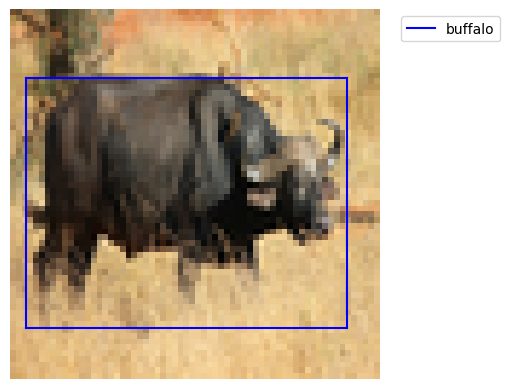

In [9]:
# Instanciation d'une Sequence
train_gen = YOLOSequence(x[:1], y[:1], 1, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

print_data_detection(batch_x, get_box_from_yolo(batch_y))

## Implémentation de YOLO

### Modèle


<center> <img src="https://drive.google.com/uc?id=1_wXc_gTIAr37STaxu3chq1EEjVSKv6a5" width=500></center>
<caption><center> Illustration de la couche de sortie de YOLO. </center></caption>

Le modèle que je vous propose ci-dessous n'est qu'une possibilité parmi beaucoup d'autres.
A vous de compléter la dernière couche pour avoir une sortie de la bonne dimension.

**Remarque importante** : comme le tenseur de sortie de YOLO est un peu complexe à manipuler, on choisit ici de regrouper l'ensemble des prédictions dans une seule et même sortie, ce qui nous oblige à utiliser la même fonction d'activation pour toutes nos sorties. On utilisera donc l'activation **linéaire** pour toutes ces sorties. On appliquera les fonctions sigmoïde et softmax pour les sorties "présence" et "probablités de classe" directement dans la fonction de coût !

In [14]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers


def create_model_YOLO(input_shape=(64, 64, 3)):
  input_layer = Input(shape=input_shape)

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  ### A COMPLETER
  output = Conv2D(NB_CLASSES + 5 * BOX_PER_CELL, CELL_PER_DIM, activation="linear", padding="same", kernel_initializer = 'he_normal')(conv4)

  model = Model(input_layer, output)

  return model

In [15]:
model = create_model_YOLO()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        36928     
                                                           

### Fonction de coût

<center> <img src="https://drive.google.com/uc?id=1Fbt_Wh_BqZj8Pwt3-04325ItCkQp5G9X" style="width:500;height:300px;"></center>
<caption><center> Détail de la fonction de perte définie dans l'article YOLO v1 </center></caption>

Nous arrivons maintenant à la partie délicate de l'implémentation de YOLO : la définition de la fonction de coût à utiliser.

Comme nous l'avons vu dans le TP4, lorsque l'on écrit une fonction de coût personnalisée en Keras, il est nécessaire d'utiliser uniquement les fonctions présentes sur la page suivante :
https://keras.rstudio.com/articles/backend.html

En effet cette fonction de coût qui sera appelée pendant l'entraînement traitera des tenseurs, et non des tableau *numpy*. On doit donc utiliser la librairie Tensorflow qui permet de manipuler les tenseurs.

Une partie essentielle de la fonction est déjà écrite : celle qui permet de séparer les données des cellules dites "vide" (la vérité terrain ne contient pas de boîte englobante) des "non vides".

Le détail de la fonction de coût est indiqué ci-dessus : dans l'article $\lambda_{\text{coord}} = 5$ et $\lambda_{\text{noobj}} = 0.5$. Les $x_i$, $y_i$, $w_i$, $h_i$ correspondent aux coordonnées d'une boîte englobante, $C_i$ correspond à la probabilité de présence d'un objet dans la cellule, et les $p_i(c)$ sont les probabilités de classe.

A vous de compléter l'expression des sous-fonctions de la fonction de coût (les fonctions *K.sum*, *K.square*, *K.sigmoid* et *K.softmax* devraient vous suffire !). **N'oubliez pas d'appliquer une sigmoïde aux présences ($C_i$) et une softmax aux probabilités de classe $p_i$) !!**

**NB : cette implémentation de la fonction de coût est très simplifiée et prend en compte le fait qu'il n'y a qu'une seule boîte englobante par cellule.**

In [16]:
from keras import backend as K

# Définition de la fonction de perte YOLO
def YOLOss(lambda_coord, lambda_noobj, batch_size):

    # Partie "verte" : sous-partie concernant l'indice de confiance et les
    # probabilités de classe dans le cas où une boîte est présente dans la cellule
    def box_loss(y_true, y_pred):
      ### A COMPLETER
      presence = K.sum(K.square(y_true[:,0] - K.sigmoid(y_pred[:,0])))
      classe = K.sum(K.square(y_true[:,5:] - K.softmax(y_pred[:,5:])))
      return presence + classe

    # Partie "bleue" : sous-partie concernant les coordonnées de boîte englobante
    # dans le cas où une boîte est présente dans la cellule
    def coord_loss(y_true, y_pred):
      pos = K.sum(K.square(y_true[:,1] - y_pred[:,1]) + K.square(y_true[:,2] - y_pred[:,2]))
      taille = K.sum(K.square(y_true[:,:5] - K.softmax(y_pred[:,5:])))
      return pos + taille


    # Partie "rouge" : sous-partie concernant l'indice de confiance
    # dans le cas où aucune boîte n'est présente dans la cellule
    def nobox_loss(y_true, y_pred):
      ### A COMPLETER
      return ...


    def YOLO_loss(y_true, y_pred):

      # On commence par reshape les tenseurs de bs x S x S x (5B+C) à (bsxSxS) x (5B+C)
      y_true = K.reshape(y_true, shape=(-1, 9))
      y_pred = K.reshape(y_pred, shape=(-1, 9))

      # On cherche (dans les labels y_true) les indices des cellules pour lesquelles au moins la première boîte englobante est présente
      not_empty = K.greater_equal(y_true[:, 0], 1)
      indices = K.arange(0, K.shape(y_true)[0])
      indices_notempty_cells = indices[not_empty]

      empty = K.less_equal(y_true[:, 0], 0)
      indices_empty_cells = indices[empty]

      # On sépare les cellules de y_true et y_pred avec ou sans boîte englobante
      y_true_notempty = K.gather(y_true, indices_notempty_cells)
      y_pred_notempty = K.gather(y_pred, indices_notempty_cells)

      y_true_empty = K.gather(y_true, indices_empty_cells)
      y_pred_empty = K.gather(y_pred, indices_empty_cells)

      return (box_loss(y_true_notempty, y_pred_notempty) + lambda_coord*coord_loss(y_true_notempty, y_pred_notempty) + lambda_noobj*nobox_loss(y_true_empty, y_pred_empty))/batch_size


    # Return a function
    return YOLO_loss

### Apprentissage

Comme d'habitude, on sépare nos données en plusieurs ensembles (ici apprentissage et validation suffiront).

In [ ]:
# Séparation des données en ensemble de validation et d'apprentissage
indices = np.arange(x.shape[0], dtype='int')
np.random.seed(1)
np.random.shuffle(indices)

x_train = x[indices[:1355]]
y_train = [y[i] for i in indices[:1355]]

x_val = x[indices[1355:]]
y_val = [y[i] for i in indices[1355:]]

y_val_YOLO = set_box_for_yolo(y_val)


Prenez le temps de tester votre modèle et votre fonction de coût, ainsi que vos réglages d'hyperparamètres, en sur-apprenant sur une image d'abord, puis sur un batch d'images. Entraînez votre réseau et visualisez ses prédictions sur les données d'entraînement, puis de validation, pour obtenir une intuition sur les valeurs de *loss* permettant d'obtenir des résultats "acceptables".

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


batch_size=16
model = create_model_YOLO()
### A COMPLETER
learning_rate = ...
opt = Adam(learning_rate=learning_rate)

# Instanciation de la séquence pour préparer les données et, plus tard,
train_gen = YOLOSequence(x_train, y_train, batch_size, augmentations=AUGMENTATIONS_TRAIN)

# Comme l'entraînement est instable, on déclenche une sauvegarde du modèle à chaque fois que
# la perte de validation atteint un nouveau minimum
model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

loss=[YOLOss(5, 0.5, batch_size)]

model.compile(loss=loss,
              optimizer=opt)

history = model.fit(train_gen,
              epochs=150,
              batch_size=batch_size,
              validation_data=(x_val/255, y_val_YOLO),
              callbacks = [model_saver])


### Test et affichage des résultats

#### Test de la version à la fin de l'entrainement

**Sur l'ensemble d'apprentissage**

In [ ]:
y_pred = model.predict(x_train/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.5, mode='pred')
print_data_detection(x_train, y_pred_YOLO)

Une fois les prédictions effectuées, vous pouvez pour aller plus rapidement uniquement relancer l'affichae aléatoire d'un seul résultat.

In [ ]:
print_data_detection(x_train, y_pred_YOLO)

**Sur l'ensemble de validation**

In [ ]:
y_pred = model.predict(x_val/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.5, mode='pred')
print_data_detection(x_val, y_pred_YOLO)

In [ ]:
print_data_detection(x_val, y_pred_YOLO)

#### Test de la meilleure version sauvegardée

La cellule ci-dessous vous permettra de charger les poids sauvegardés lorsque la meilleur performance a été atteinte sur l'ensemble de validation pendant l'entraînement.

In [ ]:
model.load_weights('tmp/best_weights')

**Sur l'ensemble d'apprentissage**

In [ ]:
y_pred = model.predict(x_train/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.5, mode='pred')
print_data_detection(x_train, y_pred_YOLO)

In [ ]:
print_data_detection(x_train, y_pred_YOLO)

**Sur l'ensemble de validation**

In [ ]:
y_pred = model.predict(x_val/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.3, mode='pred')
print_data_detection(x_val, y_pred_YOLO)

In [ ]:
print_data_detection(x_val, y_pred_YOLO)

**Si vous êtes rapide**

Une amélioration possible pourrait être d'inclure une étape supplémentaire de suppression des prédictions "non maximales" (*non-max suppression*) pour se débarasser des boîtes redondantes, comme illustré sur la figure ci-dessous :

<center> <img src="https://drive.google.com/uc?id=1XDpmffe_x_gDvsQZ_9sr6J5AuJPuSW0B" width=300>
<img src="https://drive.google.com/uc?id=1b9QgSFQlzOA7aJIbNc2Kl_eEMRDY0pQm" width=300>
</center>

Pour cela, référez-vous au cours, il faut procéder de la manière suivante. Une fois les boîtes présentant un indice de confiance inférieur à un seuil (que nous avons fixé à $0.5$ plus tôt dans le TP) éliminées, on sélectionne la boîte englobante d'indice de confiance maximal $b_{max}$. Puis on parcourt l'ensemble des autres prédictions, et on élimine celles associées à la même classe qui présentent une intersection sur union avec $b_{max}$ supérieure à un second seuil (que, soyons honnêtes, on prend également souvent égal à $0.5$).

On procède ainsi jusqu'à avoir visité toutes les boîtes !


